# 1. Describe the data
- It has 24 observations.
- There are 2 variables:
    - coag: Coagulation time (in seconds).
    - diet: Type of diet, with levels “A”, “B”, “C”, and “D”.
- Twenty-four animals were randomly assigned to four diets, and blood coagulation time was measured from random blood samples. Data from Box et al. (1978):

# 2. Load packages and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import faraway.utils

In [3]:
import faraway.datasets.coagulation
coagulation = faraway.datasets.coagulation.load()
coagulation.head()

,coag,diet
1,62,A
2,60,A
3,63,A
4,59,A
5,63,B


# 3. Pre-analysis
- Preliminary graphical analysis is essential before fitting. Side-by-side boxplots are popular for comparison, but plotting individual points is better for smaller datasets.

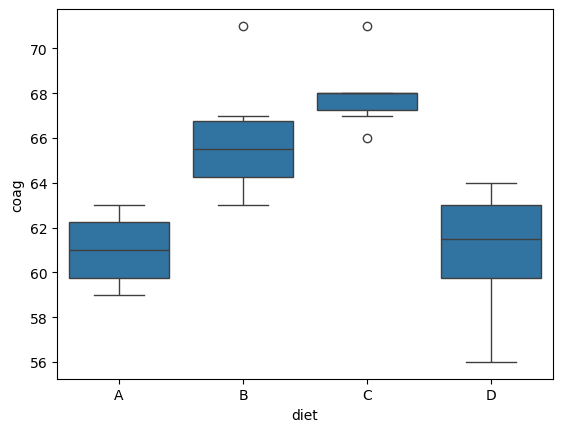

In [4]:
sns.boxplot(x="diet", y="coag", data=coagulation);

- The boxplot shows variation across the four levels, but diet C's median and upper quartile are the same.
- In this data, several observations are identical. Direct plotting obscures this. A swarmplot perturbs identical points for distinction.
- The swarmplot reveals ties in diets C and D.

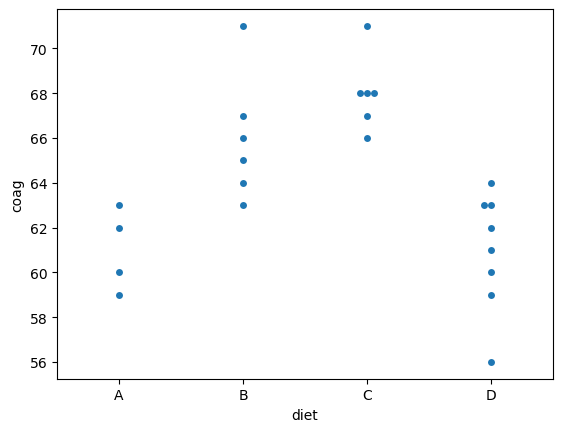

In [5]:
sns.swarmplot(x="diet", y="coag", data=coagulation);

- We check for several features in these plots: equality of variance (satisfied here), skewness indicating non-normality (none here), and outliers (none here).
- Diagnostics for influence are unnecessary, as leverages depend on $J_i$. If $J_i = 1$ (one observation per level), the effect estimate is based on that single point, making it clearly influential.

# 4. One-factor models
- Linear models with only categorical predictors (factors) are traditionally called ANOVA problems. The goal is to partition the response variance among predictors and error. Scheffé (1959) used specialized formulas for different models, but this approach is complex. Instead, we can use a regression-based approach: $y = X\beta + \epsilon$, applying our existing inferential methods.
- In ANOVA problems, predictors are qualitative and called factors with different levels. Regression parameters are termed effects. We focus on fixed-effects models, where parameters are fixed but unknown. Random-effects models are not covered here.

## 4.1. The model
- Suppose we have a factor $\alpha$ with levels $i = 1, \ldots, I$, and observations within each level labeled $j = 1, \ldots, J_i$. The model is $y_{ij} = \mu + \alpha_i + \varepsilon_{ij}$.
- The model parameters are not uniquely identifiable. For example, adding a constant to $\mu$ and subtracting it from each $\alpha_i$ keeps the fit unchanged. To resolve this, we impose restrictions on the parameters. Possible approaches include:
    - One option is to remove $\mu$ and estimate $I$ dummy variables for $\alpha_i$ at each level $i = 1, \ldots, I$. This works for a single factor but is challenging with multiple factors, requiring the removal of more parameters.
    - Another approach is to set $ \alpha_1 = 0 $, making $ \mu $ the expected mean response for the first level, and $ \alpha_i $ (for $ i \neq 1 $) the difference from the first level. The first level is the reference or baseline level. This can be done using treatment contrasts.
    - A third approach is to set the sum of all $ \alpha_i $ values to 0. Here, $ \mu $ represents the mean response across all levels, and $ \alpha_i $ represents the difference between each level and the overall mean. This approach uses sum contrasts.
- The choice of constraint determines how the $X$-matrix is generated in the code. Once the $X$-matrix is generated, the parameters (effects) can be estimated using standard methods, along with their standard errors. Regardless of the constraint and coding choice, the fitted values and residuals will remain the same.
- After estimating the effects, the next step is to test for differences in factor levels. The null and alternative hypotheses depend on the coding used. For treatment coding with a reference level, the null hypothesis is $\alpha_2 = \alpha_3 = \ldots = \alpha_I = 0$. Hypotheses may differ for other coding methods. It is often easier to state the hypotheses in terms of models:
$$H_0: y_{ij} = \mu + \epsilon_{ij}$ vs. $H_1: y_{ij} = \mu + \alpha_i + \epsilon_{ij}$$
- To test for differences in levels, we calculate the residual sum of squares and degrees of freedom for two models, then use an F-test. The outcome is the same regardless of coding or constraint. If we do not reject the null hypothesis, we check for transformations and outliers. If we reject it, we investigate which factor levels differ.

In [6]:
# Fit the model using the default treatment coding:
lmod = smf.ols("coag ~ diet", coagulation).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept 61.000  1.183   51.55  0.0000
diet[T.B]  5.000  1.528    3.27  0.0038
diet[T.C]  7.000  1.528    4.58  0.0002
diet[T.D] -0.000  1.449   -0.00  1.0000

n=24 p=4 Residual SD=2.366 R-squared=0.67


- Diet A is the reference level and has a mean response time of 61. Diets B, C, and D are 5, 7, and 0 seconds larger, respectively, on average. Examine the design matrix to understand the coding:

In [7]:
import patsy
p = patsy.dmatrix('~ diet', coagulation)
p[[0, 4, 10, 16],:]

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.]])

- We printed only the first observation of each group. The three test statistics compare each group to the reference level A. While interesting, they do not determine if there is a significant difference between any levels. This test can be obtained as:

In [8]:
sm.stats.anova_lm(lmod)

,df,sum_sq,mean_sq,F,PR(>F)
diet,3.0,228.0,76.0,13.571429,0.000047
Residual,20.0,112.0,5.6,NaN,NaN


- We see a difference in the levels, but this test does not specify which levels differ.
- We can fit the model without an intercept term as in:

In [9]:
lmodi = smf.ols("coag ~ diet-1", coagulation).fit()
lmodi.sumary()

         coefs stderr tvalues pvalues
diet[A] 61.000  1.183   51.55  0.0000
diet[B] 66.000  0.966   68.32  0.0000
diet[C] 68.000  0.966   70.39  0.0000
diet[D] 61.000  0.837   72.91  0.0000

n=24 p=4 Residual SD=2.366 R-squared=0.67


- We can read the level means directly. To test if the means are equal, fit the null model and use an F-test:

In [10]:
lmodnull = smf.ols("coag ~ 1", coagulation).fit()
sm.stats.anova_lm(lmodnull, lmod)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,23.0,340.0,0.0,NaN,NaN,NaN
1,20.0,112.0,3.0,228.0,13.571429,0.000047


- We get the same F-statistic and p-value as in the first coding.

In [11]:
sm.stats.anova_lm(lmodnull, lmodi)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,23.0,340.0,0.0,NaN,NaN,NaN
1,20.0,112.0,3.0,228.0,13.571429,0.000047


In [12]:
# We can also use a sum coding:
from patsy.contrasts import Sum
lmods = smf.ols("coag ~ C(diet,Sum)", coagulation).fit()
lmods.sumary()

                   coefs stderr tvalues pvalues
Intercept         64.000  0.498  128.54  0.0000
C(diet, Sum)[S.A] -3.000  0.974   -3.08  0.0059
C(diet, Sum)[S.B]  2.000  0.845    2.37  0.0282
C(diet, Sum)[S.C]  4.000  0.845    4.73  0.0001

n=24 p=4 Residual SD=2.366 R-squared=0.67


- The estimated overall mean response is 64. The mean responses for A, B, and C are 61, 66, and 68, respectively. Using the sum constraint, $\hat{\alpha}_D = -(-3 + 2 + 4) = -3$, so the mean for D is $64 - 3 = 61$. Note that $\hat{\alpha}$ and $R^2$ remain unchanged.
- Any of these three methods yield similar results.
    - Dropping the intercept is less convenient due to the extra step for the F-test and doesn't scale well to multi-factor experiments.
    - The other two methods can be chosen based on preference. Treatment coding is best when the reference level is a control group. We will use treatment coding by default in this book.

## 4.2 Diagnostics
- For ANOVA models, fewer diagnostics are needed, but it's still important to plot residuals vs. fitted values and create a Q-Q plot of the residuals. Transforming the predictor is unnecessary, but transforming the response is reasonable. These diagnostics are shown in Figure:

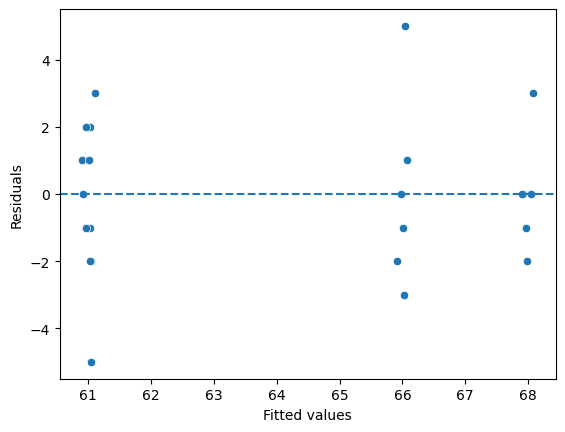

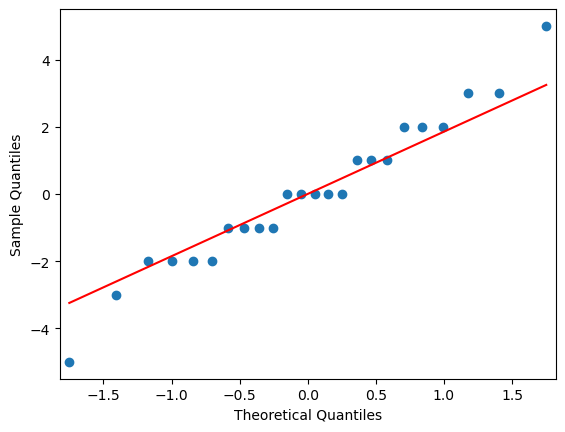

In [13]:
p = sns.scatterplot(x=lmod.fittedvalues + \
    np.random.uniform(-0.1,0.1, len(coagulation)), y = lmod.resid)
p.axhline(0, ls='--')
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
sm.qqplot(lmod.resid, line="q");

- The data and fitted values are integers, causing some discreteness in the Q-Q plot. Discrete data can't be normally distributed, but the residuals are approximately normal, allowing us to proceed with inference. The discreteness appears in the residual-fitted plot, where points are jittered for clarity.
- Levene's test examines the homogeneity of error variance by using the absolute residuals as the response in a new one-way ANOVA. To minimize outlier influence, group medians should be used instead of means. A significant result indicates nonconstant variance.
- Most tests and confidence intervals (CIs) are relatively insensitive to nonconstant variance. Action is only needed if the Levene test is significant at the 1% level.

In [14]:
# Calculate the median coagulation time for each diet group and assign it to a new column 'meds'
coagulation['meds'] = coagulation.groupby('diet').coag.transform('median')

# Calculate the absolute deviation from the median for each observation and assign it to a new column 'mads'
coagulation['mads'] = abs(coagulation.coag - coagulation.meds)

# Fit an ordinary least squares (OLS) regression model with 'mads' as the response variable and 'diet' as the predictor
lmodb = smf.ols('mads ~ diet', coagulation).fit()

# Perform an ANOVA on the fitted model to test for differences in the absolute deviations among diet groups
sm.stats.anova_lm(lmodb)

,df,sum_sq,mean_sq,F,PR(>F)
diet,3.0,4.333333,1.444444,0.649189,0.592646
Residual,20.0,44.500000,2.225000,NaN,NaN


- The large p-value indicates no evidence of nonconstant variance. The `stats.levene` function from `scipy` can be used similarly.

In [15]:
# Split the data into groups based on the 'diet' column
groups = [group['coag'].values for name, group in coagulation.groupby('diet')]

# Perform Levene's test for homogeneity of variances
stats.levene(*groups)

LeveneResult(statistic=0.6491885143570536, pvalue=0.5926459065720917)

In [16]:
# An alternative test is due to Bartlett
# Perform Bartlett's test for homogeneity of variances on coagulation times for each diet group
# The test compares the variances of the 'coag' column for diets A, B, C, and D
stats.bartlett(coagulation.coag[coagulation.diet == "A"],
               coagulation.coag[coagulation.diet == "B"],
               coagulation.coag[coagulation.diet == "C"],
               coagulation.coag[coagulation.diet == "D"])

BartlettResult(statistic=1.6679561088149575, pvalue=0.6440812243179765)

- Again, no difference is found. Levene's test is more robust to outliers.

## 4.3. Pairwise Comparisons
- After detecting differences in factor levels, the focus shifts to identifying which levels or combinations differ. Asking if a particular level is significant is meaningless without a comparison. Any meaningful test must involve a comparison. A pairwise comparison of level i and j can be made using a CI for $α_i - α_j$ using:
$$ {\hat{\alpha}}_i-{\hat{\alpha}}_j\pm t_{df}^{{\alpha}/{2}}se\ \left({\hat{\alpha}}_i-{\hat{\alpha}}_j\right) $$
- Where ${\hat{\alpha}}_i-{\hat{\alpha}}_j=\hat{\sigma}\sqrt{\frac{1}{J_i}+\frac{1}{J_j}}$ and df = n – I.
- A test for $α_i = α_j$ checks if zero lies in the interval. For example, a 95% CI for B - A shows a difference of 5.0 with a standard error of 1.53. Calculating differences not involving the reference level A requires more effort. The interval is:

In [17]:
lmod.params.iat[1] + np.array([-1, 1]) * stats.t.ppf(0.975,20) * lmod.bse.iat[1]
# lmod.params[1]: The estimated value of the second parameter in the model (B compared A)
# np.array([-1, 1]): An array to create the lower and upper bounds of the confidence interval
# stats.t.ppf(0.975, 20): The critical value from the t-distribution for a 95% confidence interval with 20 degrees of freedom
# lmod.bse[1]: The standard error of the second parameter estimate

array([1.8136382, 8.1863618])

- Since zero is not in the interval, the difference is significant. This is fine for one test, but we often want multiple comparisons. With $\alpha = 5\%$ and the null hypothesis true, six pairwise comparisons among four levels have about a 20% chance of finding at least one significant difference.
    - For one comparison at a 5% significance level, there's a 5% chance of a random significant difference. For six comparisons, the probability of no significant difference in any is $0.95^6 \approx 0.735$. Thus, the chance of at least one significant difference is $1 - 0.735 = 0.265$, or about 26.5%.
- When we have more levels (groups) in an experiment, the chance of making a Type I error (false positive) increases. A Type I error happens when you think there's a difference or effect when there really isn't.
- The Least Significant Difference (LSD) method uses t-tests for multiple comparisons. It's not recommended because it doesn't control well for the increased risk of Type I errors.
- One might argue that choosing only "interesting" comparisons reduces the number of tests and the problem's magnitude. If we perform only a few tests, we can use the Bonferroni adjustment for a simple correction. However, "interesting" comparisons are usually chosen after examining the fitted model, implying all comparisons are considered, even if not explicitly tested. If comparisons were pre-decided before examining the fit, a simple adjustment could be justified. However, this is rare and hard to prove. Typically, we need to adjust for all pairwise comparisons.
- To make the adjustment, several approaches exist. One of the simplest is Tukey's honest significant difference (HSD), which uses the studentized range distribution, derived as follows:
    - Consider i.i.d. random variables $X_1, X_2, \ldots, X_n$ from a normal distribution with mean $\mu$ and variance $\sigma^2$. Let $R = max_i X_i - min_i X_i$ be the range, the difference between the maximum and minimum $X_i$. Dividing $R$ by an estimate of $\sigma$ (denoted $\hat{\sigma}$) gives a new random variable following the studentized range distribution, $q_{n,\nu}$, where $\nu$ is the degrees of freedom used in estimating $\sigma$.
    - The Turkey Cis: ${\hat{\alpha}}_i-{\hat{\alpha}}_j\pm\frac{q_{I,df}}{\sqrt2}\hat{\sigma}\sqrt{\frac{1}{J_i}+\frac{1}{J_j}}$
    - When group sample sizes differ greatly, Tukey's HSD test may be overly conservative, potentially failing to detect significant differences. This occurs because the test accounts for within-group variability, and unequal sample sizes can lead to an overly cautious result.

In [18]:
thsd = sm.stats.multicomp.pairwise_tukeyhsd(coagulation.coag, coagulation.diet)
thsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,5.0,0.0183,0.7246,9.2754,True
A,C,7.0,0.001,2.7246,11.2754,True
A,D,0.0,1.0,-4.056,4.056,False
B,C,2.0,0.4766,-1.8241,5.8241,False
B,D,-5.0,0.0044,-8.5771,-1.4229,True
C,D,-7.0,0.0001,-10.5771,-3.4229,True


- Only the A - D and B - C differences are not significant, confirming our impression. The intervals can be plotted as shown in Figure:

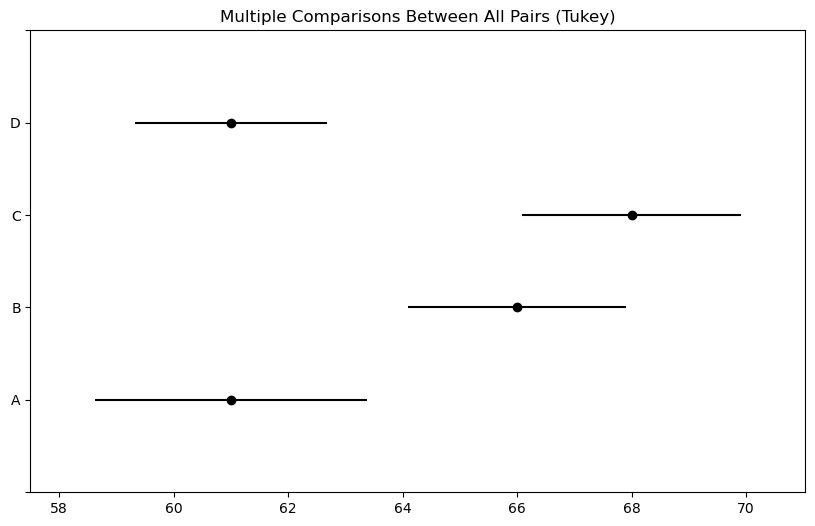

In [19]:
fig = thsd.plot_simultaneous()

- The Tukey method focuses on the largest difference, assuming the worst. Alternatives like Newman-Keuls, Duncan's multiple range, and Waller-Duncan are less pessimistic or don't consider all pairwise comparisons. For more details, see Hsu (1996).